In [1]:
from collections import Counter
import os
import re

import cv2
import hdbscan
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap
from PIL import Image, ImageDraw, ImageFilter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

import mgitools.os_helpers as os_helpers

/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## imaging

In [2]:
outputs_dir = '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/'
figures_dir = os.path.join(outputs_dir, 'f2f_integration_figures')

if not os.path.isdir(figures_dir):
    os.mkdir(figures_dir)

In [3]:
# grab rois cells
fps = []
for fp in os_helpers.listfiles(outputs_dir):
    if '.tsv' in fp and 'cluster_trained' in fp:
        fps.append(fp)
fps

['/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P004_cluster_trained/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P003_cluster_trained/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P002_cluster_trained/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P005_cluster_trained/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P000_cluster_trained/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P006_cluster_trained/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P001_cluster_trained/figures/cell_intensities.tsv']

In [4]:
# data = []
# cell_ids = []
# columns = []
# rois = []

# for fp in sorted(fps):
#     f = open(fp)
#     columns = f.readline().strip().split('\t')
#     for line in f:
#         pieces = line.strip().split('\t')
#         cell_ids.append(pieces[0])
#         data.append([float(x) for x in pieces[1:]])
#         rois.append(re.sub(r'^.*outputs/(.*)/figures.*$', r'\1', fp))
#     f.close()

In [5]:
data = None
cell_ids = []
columns = []
rois = []

for fp in sorted(fps):
    f = open(fp)
    columns = f.readline().strip().split('\t')
    
    X = []
    for line in f:
        pieces = line.strip().split('\t')
        cell_ids.append(pieces[0])
        X.append([float(x) for x in pieces[1:]])
        rois.append(re.sub(r'^.*outputs/(.*)/figures.*$', r'\1', fp))
    
    X = np.asarray(X)
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)
    if data is None:
        data = np.copy(X)
    else:
        data = np.vstack((data, X))
    
    f.close()

In [6]:
columns

['Ki67',
 'CD20',
 'CD3',
 'CD56',
 'PDL1',
 'CD8',
 'SOX10',
 'PD1',
 'CD45',
 'CD68',
 'CD4',
 'FOXP3']

In [7]:
imaging_df = pd.DataFrame(data=data, columns=columns, index=cell_ids)
imaging_df = imaging_df.reindex(sorted(imaging_df.columns), axis=1)

imaging_df.head()

,CD20,CD3,CD4,CD45,CD56,CD68,CD8,FOXP3,Ki67,PD1,PDL1,SOX10
c671f5ca-2ae2-41d9-8531-bd37f8593273,8.220920,4.343553,23.957619,9.218215,27.968440,12.739405,3.231740,4.012624,0.825068,3.058611,10.334536,20.918846
6c695b7e-2d18-4624-8a16-4ce111fa3958,7.037940,4.205962,22.233062,7.986450,27.085818,10.833785,3.040650,4.324300,6.855465,3.030714,10.930443,21.095754
71c54266-7e03-468b-a34b-d34a9b68cd15,8.508183,4.066322,25.397933,10.260121,30.711456,15.474591,3.173127,3.925065,0.888028,2.875108,9.370370,20.925065
c9a925c2-d252-4cfc-b906-1ac757f1d7e7,8.146375,4.276334,23.745554,9.021888,29.086183,16.109439,3.102599,4.173735,0.879617,2.916553,10.255814,22.506156
1c968c20-107d-4964-979a-4abad46b31c8,6.766169,3.776119,25.014925,7.981758,27.240464,12.117745,2.716418,4.281924,1.195688,2.867330,9.535655,18.152570


In [8]:
X = imaging_df.values

In [9]:
X.shape

(20100, 12)

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
# embedder = umap.UMAP(
#     n_neighbors=60,
#     min_dist=0.,
#     n_components=2,
#     random_state=42,
# ).fit(X)

# X_embedded = embedder.transform(X)

In [12]:
X_embedded = umap.UMAP(
    n_neighbors=30,
    min_dist=0.,
    n_components=2,
    random_state=42,
).fit_transform(X)

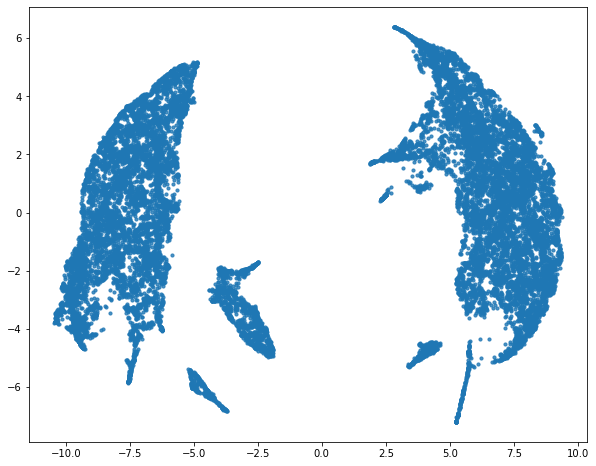

In [13]:
plt.figure(figsize=(10,8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha = .8, s=10)

plt.savefig(os.path.join(figures_dir, 'scattered_cells.png'), dpi=300)

In [14]:
labels = hdbscan.HDBSCAN(
    min_samples=80,
    min_cluster_size=80,
).fit_predict(X_embedded)

In [15]:
# clusterer = AgglomerativeClustering()
# clustering = clusterer.fit(X)
# labels = clustering.labels_

In [16]:
print(X_embedded.shape, len(cell_ids))

(20100, 2) 20100


In [17]:
plotting_df = pd.DataFrame(data=X_embedded, columns=['UMAP1', 'UMAP2'], index=cell_ids)
plotting_df['cluster'] = labels
plotting_df['roi'] = rois

for i, c in enumerate(columns):
    ls = X[:, i]
    plotting_df[c] = list(ls)

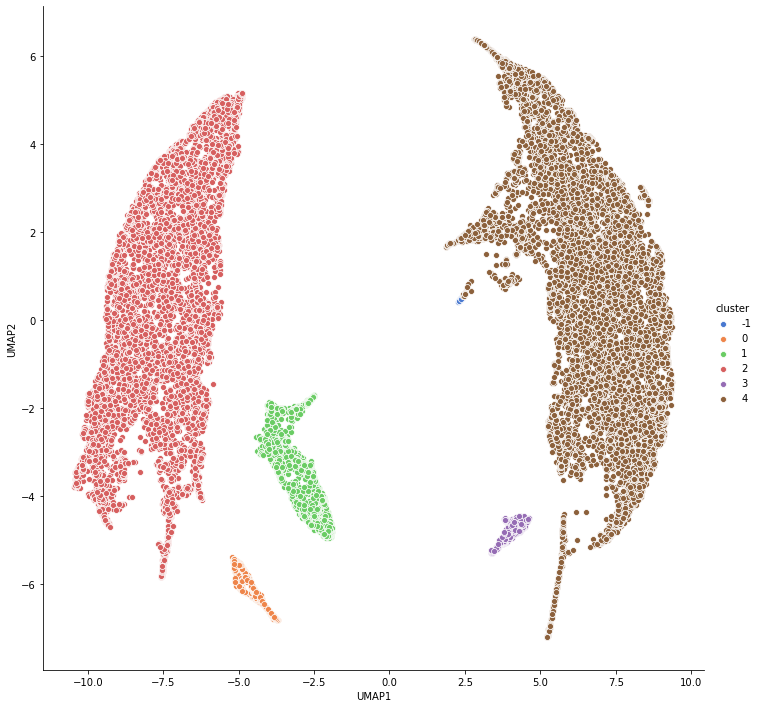

In [18]:
axs = sns.pairplot(plotting_df, x_vars=['UMAP1'], y_vars=['UMAP2'], hue='cluster', height=10,
                  palette='muted')

plt.savefig(os.path.join(figures_dir, 'labeled_cells.png'), dpi=300)

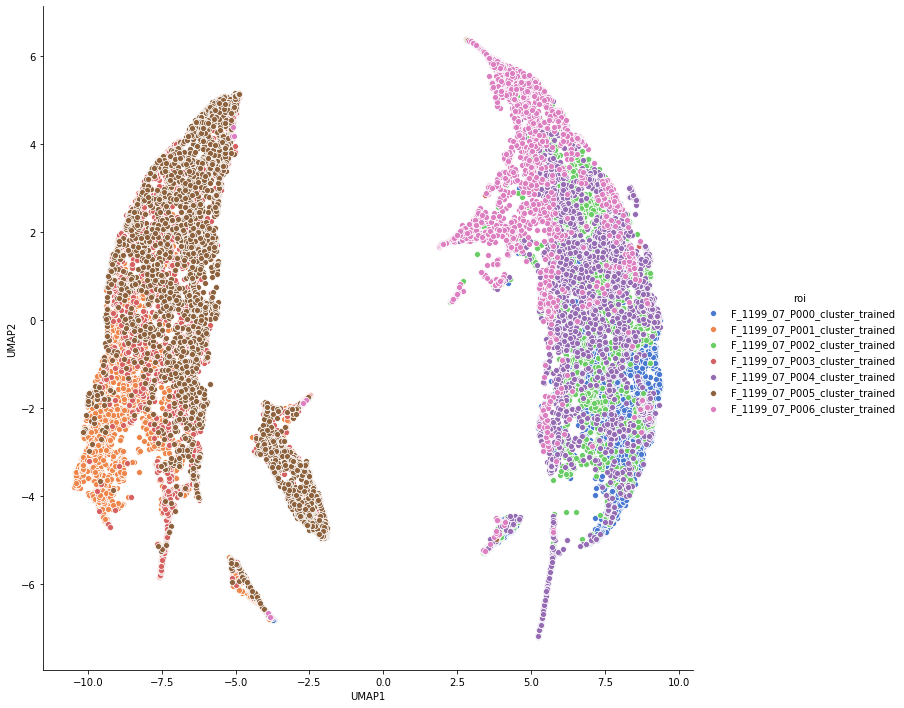

In [19]:
axs = sns.pairplot(plotting_df, x_vars=['UMAP1'], y_vars=['UMAP2'], hue='roi', height=10,
                  palette='muted')
plt.savefig(os.path.join(figures_dir, 'roi_cells.png'), dpi=300)

Ki67


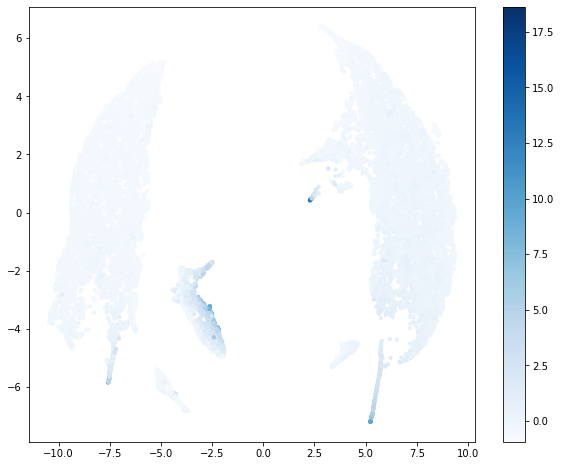

CD20


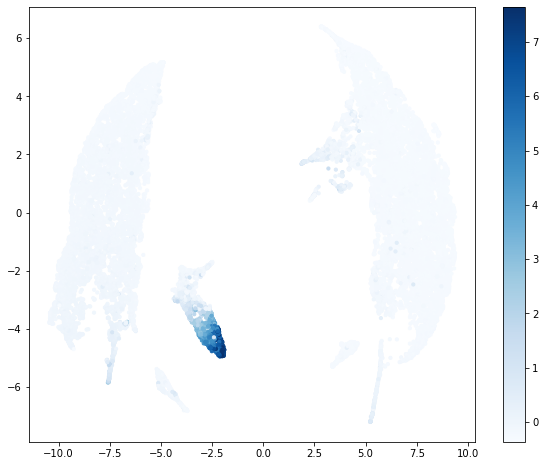

CD3


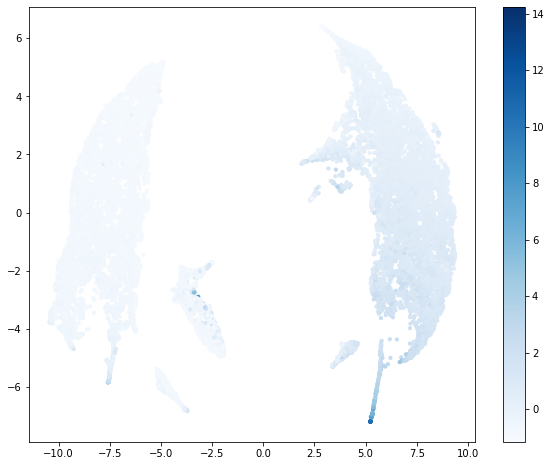

CD56


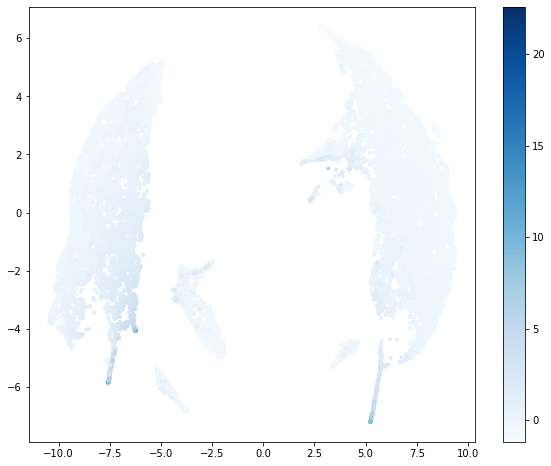

PDL1


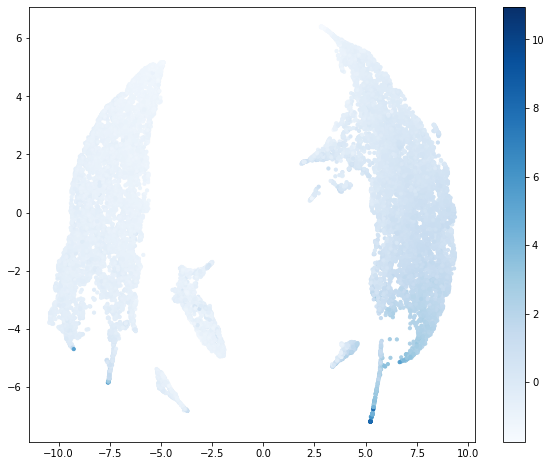

CD8


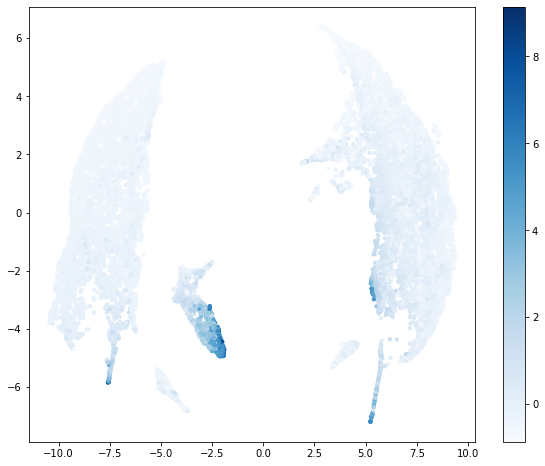

SOX10


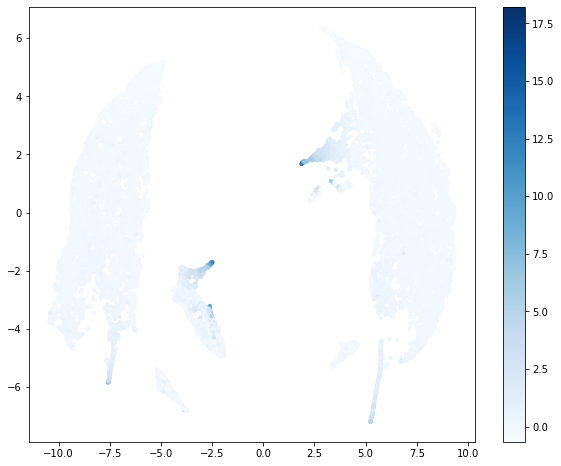

PD1


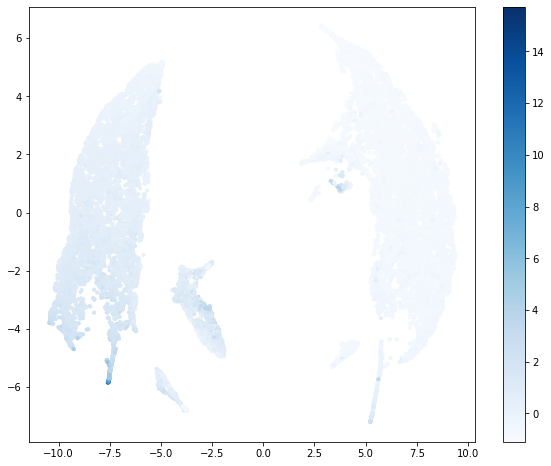

CD45


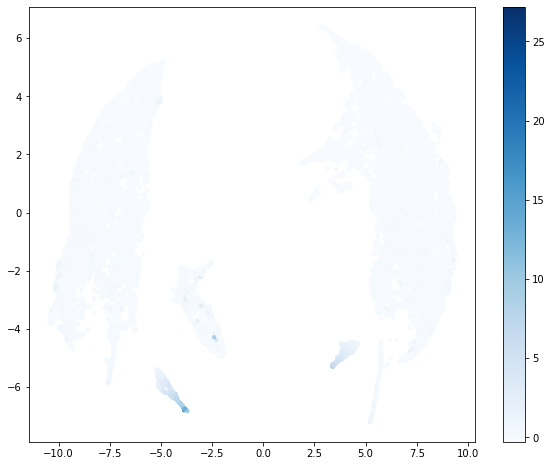

CD68


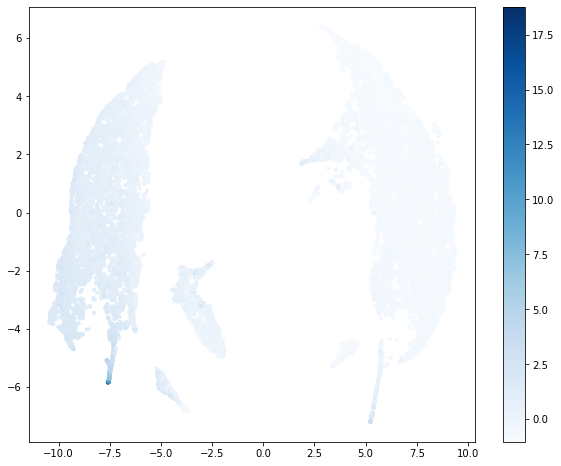

CD4


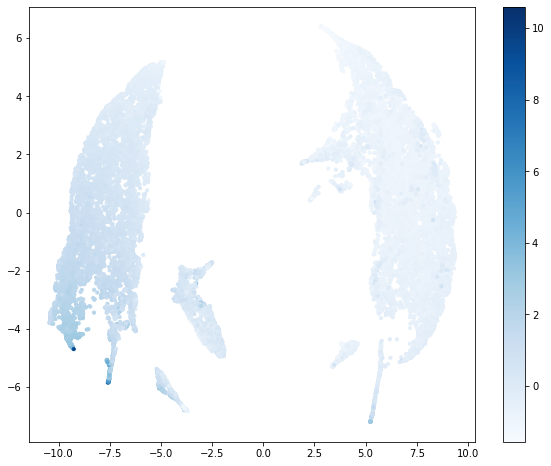

FOXP3


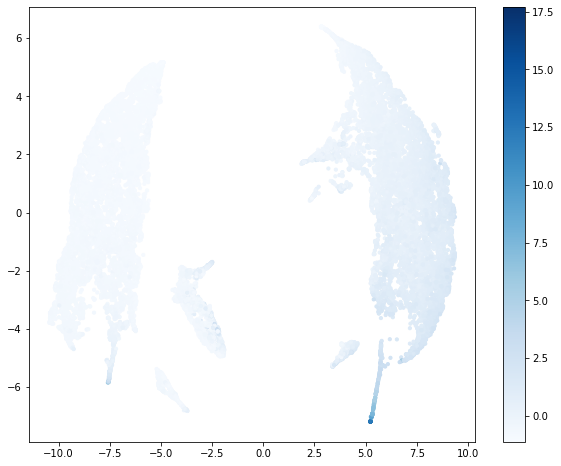

In [20]:
for i, c in enumerate(columns):
    print(c)
    plt.figure(figsize=(10,8))
    plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
    cbar = plt.colorbar()
    plt.savefig(os.path.join(figures_dir, f'{c}.png'), dpi=300)
    plt.show()

### integrate with segmented cells

In [21]:
# grab cells
fps = []
for fp in os_helpers.listfiles(outputs_dir):
    if 'slide.json' in fp and 'cluster_trained' in fp:
        fps.append(fp)
fps

['/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P004_cluster_trained/figures/slide.json',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P003_cluster_trained/figures/slide.json',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P002_cluster_trained/figures/slide.json',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P005_cluster_trained/figures/slide.json',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P000_cluster_trained/figures/slide.json',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P006_cluster_trained/figures/slide.json',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P001_cluster_trained/figures/slide.json']

In [22]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [23]:


id_to_cluster = {i:row['cluster'] for i, row in plotting_df.iterrows()}

In [24]:
def decode_masks(cell, width, height):
    cell['nucleus_mask'] = rle_decode(cell['nucleus_mask'], (height, width)).astype(bool)
    cell['cell_mask'] = rle_decode(cell['cell_mask'], (height, width)).astype(bool)
    
    return cell

def get_annotated_slide_image(fp):
    slide_json = json.load(open(fp))
    
    cells = [decode_masks(c, slide_json['width'], slide_json['height'])
         for c in slide_json['cells']]
    
    images = [np.array(Image.new('RGB', (cells[0]['cell_mask'].shape[1], cells[0]['cell_mask'].shape[0]) , c))
          for c in sns.color_palette(palette='muted').as_hex()]
    
    image = np.zeros((cells[0]['cell_mask'].shape[0], cells[0]['cell_mask'].shape[1], 3), np.uint8)

    for cell in cells:
        if cell['id'] in id_to_cluster:
            img = images[int(id_to_cluster[cell['id']]) + 1]
            colored_mask = cv2.bitwise_and(img, img, mask=cell['cell_mask'].astype(np.uint8))
            image = cv2.add(image, colored_mask)
            
    return image

/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P004_cluster_trained/figures/slide.json


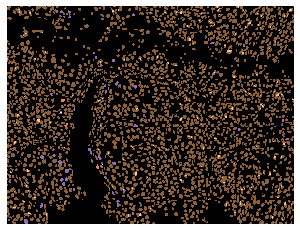

/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P003_cluster_trained/figures/slide.json


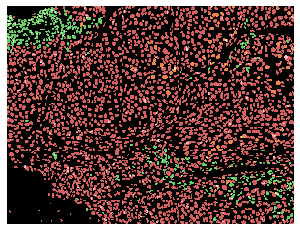

/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P002_cluster_trained/figures/slide.json


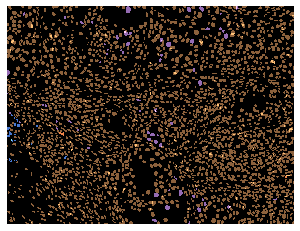

/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P005_cluster_trained/figures/slide.json


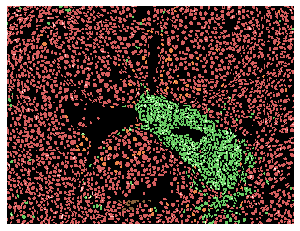

/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P000_cluster_trained/figures/slide.json


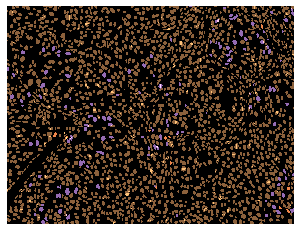

/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P006_cluster_trained/figures/slide.json


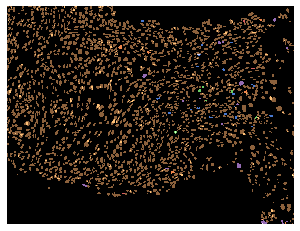

/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P001_cluster_trained/figures/slide.json


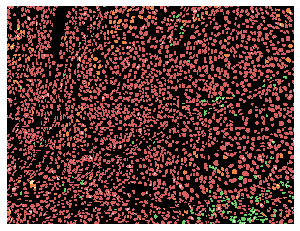

In [25]:
for fp in fps:   
    print(fp)
    roi = re.sub(r'^.*(P00[0-9]).*$', r'\1', fp)
    image = get_annotated_slide_image(fp)
    axs = plt.imshow(image)
    plt.axis('off')
    plt.savefig(os.path.join(figures_dir, f'2d_{roi}.png'), dpi=300)
    plt.show(axs)

## single cell

In [ ]:
gene_table_fp = '/Users/erikstorrs/Downloads/mart_export.txt'
gene_df = pd.read_csv(gene_table_fp, sep='\t')
gene_df.head()

In [ ]:
gene_id_to_gene_name = {r['Gene stable ID']:r['Gene name'] for i, r in gene_df.iterrows()}

In [ ]:
input_fp = '/Users/erikstorrs/Documents/ding/cell-segmentation/data/scRNA/normalized_exp_1199_07.txt'

In [ ]:
sc_df = pd.read_csv(input_fp, sep='\t')

In [ ]:
sc_df.head()

In [ ]:
# remove genes with high missingness
idxs = []
for i, (idx, row) in enumerate(sc_df.iterrows()):
    if i % 5000 == 0:
        print(i)
        
    c = Counter(list([int(x) for x in row]))
    if c[0] == int(sc_df.shape[1]):
        idxs.append(idx)

In [ ]:
len(idxs)

In [ ]:
sc_df = sc_df.drop(idxs)

In [ ]:
sc_df.head()

In [ ]:
sc_df = sc_df.transpose()
sc_df.head()

In [ ]:
# replace columns with gene names
cs = [gene_id_to_gene_name.get(c, c) for c in sc_df.columns]
sc_df.columns = cs
sc_df.head()

In [ ]:
keep = ['SOX10', 'CD3G', 'CD4', 'CD8A', 'MS4A1', 'PTPRC', 'NCAM1', 'CD68', 'FOXP3', 'CD274', 'PDCD1', 'MKI67']
keep_set = set(keep)

In [ ]:
# replace only the columns we are interested in 
for c in sc_df.columns:
    if c in keep_set:
        ls = list(sc_df[c])
        ls = [np.nan if x==0.0 else x for x in ls]
        sc_df[c] = ls
sc_df[keep].head()

In [ ]:
sc_df.shape

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

In [ ]:
imp = IterativeImputer(max_iter=20, random_state=0, n_nearest_features=50)

In [ ]:
%%time
X = np.copy(sc_df.values)
X = imp.fit_transform(X)

In [ ]:
sc_df = pd.DataFrame(data=X, columns=sc_df.columns, index=sc_df.index)

In [ ]:
sc_df.head()

In [ ]:
# X = np.copy(sc_df.values)

In [ ]:
# X_embedded = umap.UMAP(
#     n_neighbors=15,
#     min_dist=0.0,
# #     n_components=20,
#     n_components=50,

#     random_state=42,
# ).fit_transform(X)

In [ ]:
# labels = hdbscan.HDBSCAN(
#     min_samples=50,
#     min_cluster_size=50,
# ).fit_predict(X_embedded)

In [ ]:
# X_embedded = umap.UMAP(
#     n_neighbors=15,
#     min_dist=0.0,
#     n_components=2,
#     random_state=42,
# ).fit_transform(X_embedded)

In [ ]:
plotting_df = pd.DataFrame(data=X_embedded, columns=['UMAP1', 'UMAP2'], index=sc_df.index)
# for c in sc_df.columns:
#     plotting_df[c] = list(sc_df[c])
plotting_df['cluster'] = labels

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha = .8, s=10)

In [ ]:
axs = sns.pairplot(plotting_df, x_vars=['UMAP1'], y_vars=['UMAP2'], hue='cluster', height=10,
                  palette='muted')
# plt.savefig(os.path.join(output_figures_dir, 'clustered_cells.png'), dpi=1000)

In [ ]:
c = 'SOX10'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
c = 'CD3G'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
c = 'CD4'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
c = 'CD8A'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# cd20
c = 'MS4A1'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# cd45
c = 'PTPRC'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# cd56
c = 'NCAM1'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
c = 'CD68'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
c = 'FOXP3'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# pdl1
c = 'CD274'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# pd1
c = 'PDCD1'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# ki-67
c = 'MKI67'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
columns

In [ ]:
keep = ['SOX10', 'CD3G', 'CD4', 'CD8A', 'MS4A1', 'PTPRC', 'NCAM1', 'CD68', 'FOXP3', 'CD274', 'PDCD1', 'MKI67']
gene_to_marker = {
    'MKI67': 'Ki67',
    'PDCD1': 'PD1',
    'CD274': 'PDL1',
    'FOXP3': 'FOXP3',
    'CD68': 'CD68',
    'NCAM1': 'CD56',
    'PTPRC': 'CD45',
    'MS4A1': 'CD20',
    'CD8A': 'CD8',
    'CD4': 'CD4',
    'CD3G': 'CD3',
    'SOX10': 'SOX10'
}

In [ ]:
integrated_df = sc_df[keep]
integrated_df.columns = [gene_to_marker[c] for c in integrated_df.columns]
integrated_df = integrated_df.reindex(sorted(integrated_df.columns), axis=1)
integrated_df.head()

In [ ]:
# integrated_df.head(100)

In [ ]:
X = np.copy(integrated_df.values)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# X_embedded = embedder.transform(X)

In [ ]:
X_embedded = umap.UMAP(
    n_neighbors=30,
    min_dist=0.,
    n_components=2,

    random_state=42,
).fit_transform(X)

In [ ]:
labels = hdbscan.HDBSCAN(
    min_samples=100,
    min_cluster_size=100,
).fit_predict(X_embedded)

# labels = hdbscan.HDBSCAN(
#     min_samples=1,
#     min_cluster_size=10,
# ).fit_predict(X)

In [ ]:
# X_embedded = umap.UMAP(
#     n_neighbors=30,
#     min_dist=0.,
#     n_components=2,

#     random_state=42,
# ).fit_transform(X)

In [ ]:
plotting_df = pd.DataFrame(data=X_embedded, columns=['UMAP1', 'UMAP2'], index=integrated_df.index)
# for c in sc_df.columns:
#     plotting_df[c] = list(sc_df[c])
plotting_df['cluster'] = labels

In [ ]:
axs = sns.pairplot(plotting_df, x_vars=['UMAP1'], y_vars=['UMAP2'], hue='cluster', height=10,
                  palette='muted')

In [ ]:
for c in integrated_df.columns:
    print(c)
    plotting_df[c] = list(integrated_df[c])
    plt.figure(figsize=(10,8))
    plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
    cbar = plt.colorbar()
    plt.show()